# 1. Project Definition <a id='definition'></a>


#### Introduction


#### Problem Definition


# 2. Importing packages and setup

Importing libraries and setting up spark session

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

# pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, col, countDistinct, sum, avg, when, desc, asc, isnan, count, sort_array, concat,lit, split
from pyspark.sql.types import StringType, IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession\
        .builder\
        .appName("Sparkify")\
        .getOrCreate()

#spark.conf.set("spark.sql.shuffle.partitions", 4)

# 3. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## 3.1 Loading data

In [3]:
#Load data
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

## 3.2 Exploring data

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
# Show top two rows of df dataframe
df.show(n=2,vertical = True)

-RECORD 0-----------------------------
 artist        | Martha Tilston       
 auth          | Logged In            
 firstName     | Colin                
 gender        | M                    
 itemInSession | 50                   
 lastName      | Freeman              
 length        | 277.89016            
 level         | paid                 
 location      | Bakersfield, CA      
 method        | PUT                  
 page          | NextSong             
 registration  | 1538173362000        
 sessionId     | 29                   
 song          | Rockpools            
 status        | 200                  
 ts            | 1538352117000        
 userAgent     | Mozilla/5.0 (Wind... 
 userId        | 30                   
-RECORD 1-----------------------------
 artist        | Five Iron Frenzy     
 auth          | Logged In            
 firstName     | Micah                
 gender        | M                    
 itemInSession | 79                   
 lastName      | Long    

In [6]:
# Print schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Total number of rows
df.count()

286500

In [8]:
# Total number of columns
len(df.columns)

18

In [9]:
# Print total number of distinct artists
print('Number of distinct artists:', df.select("artist").distinct().count())

# Show distinct "artists"
df.select("artist").distinct().show()

Number of distinct artists: 17656
+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows



In [10]:
# Print total number of distinct songs
print('Number of distinct songs:', df.select("song").distinct().count())

# Show distinct "songs"
df.select("song").distinct().show()

Number of distinct songs: 58481
+--------------------+
|                song|
+--------------------+
|Never Gonna Be Al...|
|         TULENLIEKKI|
|      Underwaterboys|
|Saor (Free)/News ...|
|               New E|
|The Geeks Were Right|
|              Heaven|
|      Call Me Manana|
|             Push It|
|Cool Monsoon (Wea...|
|The Fun Lovin' Cr...|
|Turn Your Lights ...|
|          Growing Up|
|          Positivity|
|         Miracle Man|
|        I'm The Drug|
|I've Just Seen A ...|
|            Anna May|
|All The Things Sh...|
|    Blue Suede Shoes|
+--------------------+
only showing top 20 rows



In [11]:
# Show top 20 most played songs
df.select(['ts','song']).groupby('song').count().sort('count', ascending = False).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|58392|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
+--------------------+-----+
only showing top 20 rows



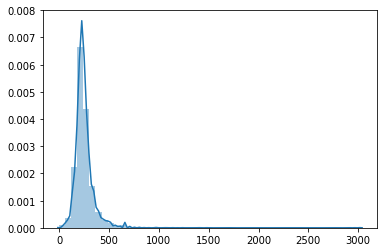

In [12]:
#Plot song 'length' distribution in seconds
sns.distplot(df.select('length').toPandas().dropna());

In [13]:
# Print total number of distinct pages
print('Number of distinct pages:', df.select("page").distinct().count())

# Count number of user per distinct "pages" - Most seen pages by users
df.select(["userId","page"]).groupby("page").count().sort("count", ascending = False).show()

Number of distinct pages: 22
+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+
only showing top 20 rows



In [14]:
# Show distinct authentication status
df.select('auth').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [15]:
# Count number of user per each authentication status
df.select('userId','auth').dropDuplicates().groupby('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out|    1|
| Cancelled|   52|
|     Guest|    1|
| Logged In|  225|
+----------+-----+



> When users are *Logged Out* or are *Guests* do not have a `userId`defined

In [16]:
# Count number of user per distinct "levels"
df.select(["userId","level"]).dropDuplicates().groupby("level").count().show()

# although a user can start with a free account and upgrade to a paid account later

+-----+-----+
|level|count|
+-----+-----+
| free|  196|
| paid|  166|
+-----+-----+



In [17]:
# Show distinct "methods"
df.select('method').distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [18]:
# Show distinct "status"
df.select(["userId","status"]).dropDuplicates().groupby("status").count().show()

+------+-----+
|status|count|
+------+-----+
|   307|  224|
|   404|  118|
|   200|  226|
+------+-----+



In [19]:
# Show total number of distinct users
df.select('userId').distinct().count()

226

In [20]:
# Show total number of distinct sessions
df.select('sessionId').distinct().count()

2354

In [21]:
# Count number of user by gender
df.select(["userId","gender"]).dropDuplicates().groupby("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|  null|    1|
|     M|  121|
+------+-----+



In [22]:
# Create 'state' column from spliting using 'location' information
df = df.withColumn('state', split(col('location'),',').getItem(1))

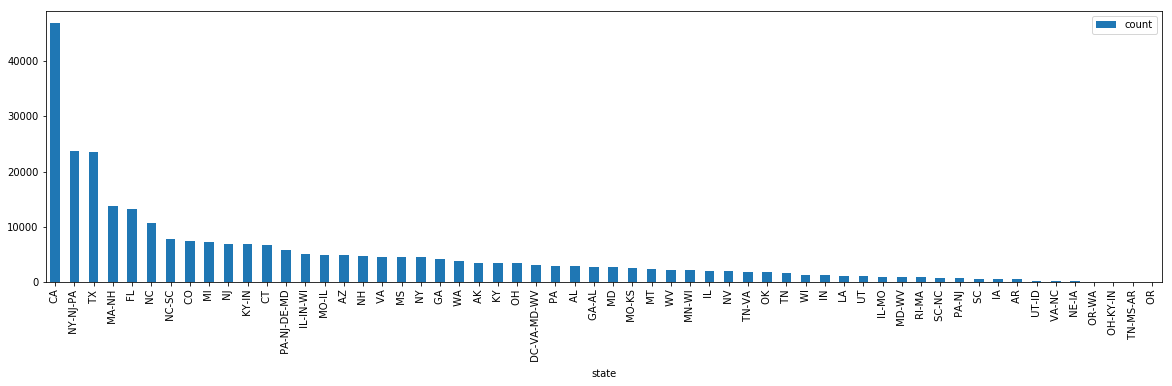

In [50]:
# Calculate the number of users in each state
users_per_state = df.select(['userId','state']).groupby('state').count().sort('count',ascending=False).toPandas()
users_per_state.plot(x = 'state', kind='bar',figsize=(20,5));

In [24]:
# Check for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical = True)

-RECORD 0--------------
 artist        | 58392 
 auth          | 0     
 firstName     | 8346  
 gender        | 8346  
 itemInSession | 0     
 lastName      | 8346  
 length        | 58392 
 level         | 0     
 location      | 8346  
 method        | 0     
 page          | 0     
 registration  | 8346  
 sessionId     | 0     
 song          | 58392 
 status        | 0     
 ts            | 0     
 userAgent     | 8346  
 userId        | 0     
 state         | 8346  



> As we can see, all the attributes that concern the session variables (like *ts, status, sessionId, userId, itemInSession, page*) are complete. So apparently there is no invalid record.

> However, there seems to be a pattern in the missing values for the remaining variables.
* `artist`, `length` and `song` have 58 392 missing values;
* `firstName`, `gender`, `lastName`, `location`, `registration` and `userAgent` have 8 346 missing values.

In [25]:
# Show 5 sessionIds where "artist" is a missing value
df.select(['sessionId','userId']).where(df.artist.isNull()).show(n=5)

+---------+------+
|sessionId|userId|
+---------+------+
|       29|    30|
|        8|     9|
|        8|     9|
|       53|    54|
|       53|    54|
+---------+------+
only showing top 5 rows



In [26]:
# Show all event of sessionId = 8 for userId = 9 (missing artist, length and song example)
df.where(df.sessionId == 8).where(df.userId == 9).sort('ts').toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,state
0,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
1,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
2,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
3,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
4,Britt Nicole,Logged In,Micah,M,83,Long,229.87710,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Walk On The Water,200,1538353146000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
5,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1538331630000,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
6,Tesla,Logged In,Micah,M,85,Long,201.06404,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Gettin' Better,200,1538353375000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
7,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1538331630000,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
8,Florence + The Machine,Logged In,Micah,M,87,Long,168.64608,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,You've Got The Love,200,1538353576000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
9,Ratatat,Logged In,Micah,M,88,Long,229.77261,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Swisha,200,1538353744000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH


> Records with missing `artist`, `song` and `length` are records that are not related to music events. For instance, it occurs when the `page` is "Thumbs Up", "Thumbs Down", "Home", "Logout", "Roll Advert", "Add to Playlist", "Upgrade", and others. It is not an error and should not be removed or filled with some value. 


In [27]:
#Check for empty values
df.select([count(when(col(c)=='', c)).alias(c) for c in df.columns]).show(vertical = True)

-RECORD 0-------------
 artist        | 0    
 auth          | 0    
 firstName     | 0    
 gender        | 0    
 itemInSession | 0    
 lastName      | 0    
 length        | 0    
 level         | 0    
 location      | 0    
 method        | 0    
 page          | 0    
 registration  | 0    
 sessionId     | 0    
 song          | 0    
 status        | 0    
 ts            | 0    
 userAgent     | 0    
 userId        | 8346 
 state         | 0    



> The **8 346** events in which `firstName`, `gender`, `lastName`, `location`, `registration` and `userAgent` are null values correspond to scenarios in which:
* users did not give permissions to capture data, for instance, by refusing browser cookies
* the user is not identified, browsing the site without logging in.

> For these same scenarios a `userId` is not generated, appearing as empty as we can see with the image above. These records will be dropped in the steps. 

## 3.3 Cleaning data

In [28]:
# Drop rows with unregistered users
df = df.filter(df.userId != "")

In [29]:
# Check again for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical = True)

-RECORD 0--------------
 artist        | 50046 
 auth          | 0     
 firstName     | 0     
 gender        | 0     
 itemInSession | 0     
 lastName      | 0     
 length        | 50046 
 level         | 0     
 location      | 0     
 method        | 0     
 page          | 0     
 registration  | 0     
 sessionId     | 0     
 song          | 50046 
 status        | 0     
 ts            | 0     
 userAgent     | 0     
 userId        | 0     
 state         | 0     



In [64]:
# get_date Function
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# get_hour Function
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour, IntegerType())

In [31]:
# Convert timestamps to date
df = df.withColumn("date", get_date(df.ts))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', state=' CA', date='2018-10-01 00:01:57')

In [65]:
# Convert timestamps to hour
df = df.withColumn("hour", get_hour(df.ts))
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', state=' CT', date='2018-10-08 12:58:54', registration_date='2018-09-27 02:45:40', churn=0, Fchurn=0, downgrade=0, Fdowngrade=0, hour=12)

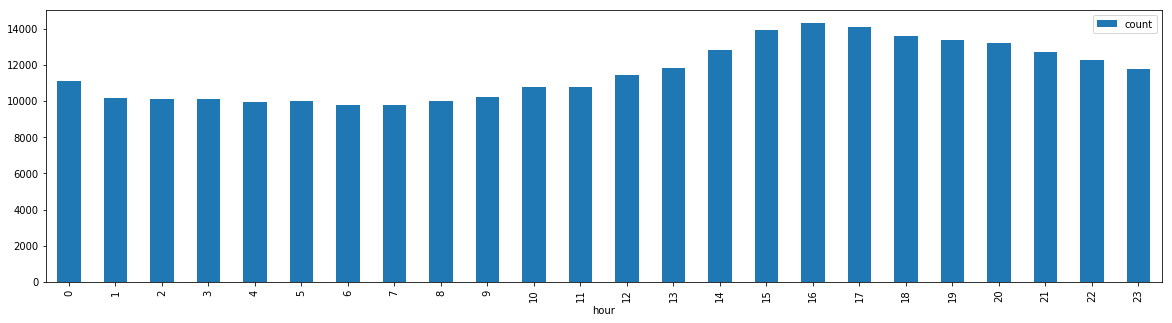

In [66]:
# Calculate the number of events per hour
events_per_hour = df.select(['userId','hour']).groupby('hour').count().sort('hour').toPandas()
events_per_hour.plot(x = 'hour', kind='bar',figsize=(20,5));

In [67]:
# Convert registration timestamp to date
df = df.withColumn("registration_date", get_date(df.registration))

# Convert registration timestamp to hour
df = df.withColumn("registration_hour", get_hour(df.registration))

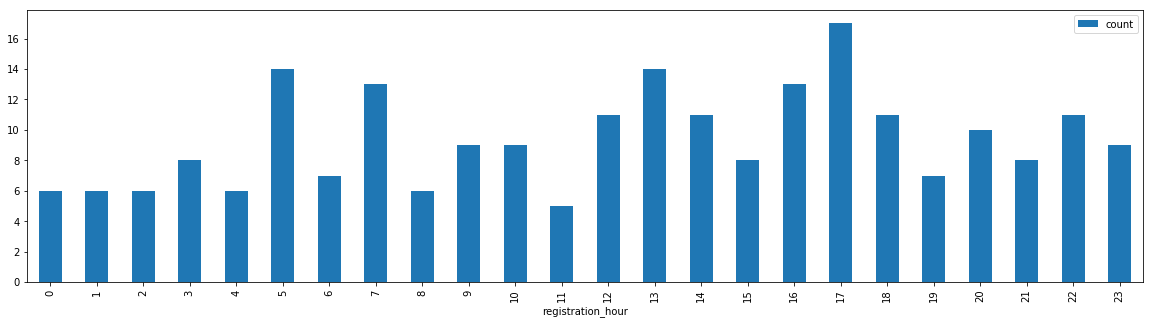

In [68]:
# Calculate the number of registations per hour
registration_per_hour = df.select(['userId','registration_hour']).dropDuplicates().groupby('registration_hour').count().sort('registration_hour').toPandas()
registration_per_hour.plot(x = 'registration_hour', kind='bar',figsize=(20,5));

# 4. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## 4.1 Define Churn events

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [33]:
# Function to identify churn events
is_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [34]:
# Create churn column 
df = df.withColumn("churn", is_churn_event("page"))

In [35]:
# Create a partitionated window by userID
windowval = Window.partitionBy("userId")

# Sum churn flag over user window
df = df.withColumn("Fchurn", sum("churn").over(windowval))

In [36]:
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', state=' CT', date='2018-10-08 12:58:54', registration_date='2018-09-27 02:45:40', churn=0, Fchurn=0)

In [37]:
print('Number of users who have churned: {}'.\
      format(df.filter(df.Fchurn != 0).select('userId').dropDuplicates().count()))
print('Number of users who have not churned: {}'.\
      format(df.filter(df.Fchurn == 0).select('userId').dropDuplicates().count()))

Number of users who have churned: 52
Number of users who have not churned: 173


## 4.2 Define Downgrade events

In [38]:
# Function to identify downgrade events
is_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [39]:
# Create downgrade column 
df = df.withColumn("downgrade", is_downgrade_event("page"))

In [40]:
# Sum downgrade flag over user window
df = df.withColumn("Fdowngrade", sum("downgrade").over(windowval))

In [41]:
print('Number of users who have downgraded: {}'.\
      format(df.filter(df.Fdowngrade != 0).select('userId').dropDuplicates().count()))
print('Number of users who have not downgraded: {}'.\
      format(df.filter(df.Fdowngrade == 0).select('userId').dropDuplicates().count()))

Number of users who have downgraded: 49
Number of users who have not downgraded: 176


In [42]:
# Check the number of user who have downgraded, and how many times
df["userId", "Fdowngrade"].dropDuplicates().groupby("Fdowngrade").count().alias("# Downgrade users").show()

+----------+-----+
|Fdowngrade|count|
+----------+-----+
|         0|  176|
|         1|   37|
|         3|    2|
|         2|   10|
+----------+-----+



## 4.3 Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.